# DDA Lab 3

# Simran Kaur

# 311443

# Exercise Sheet 3

## Distributed K-means Clustering

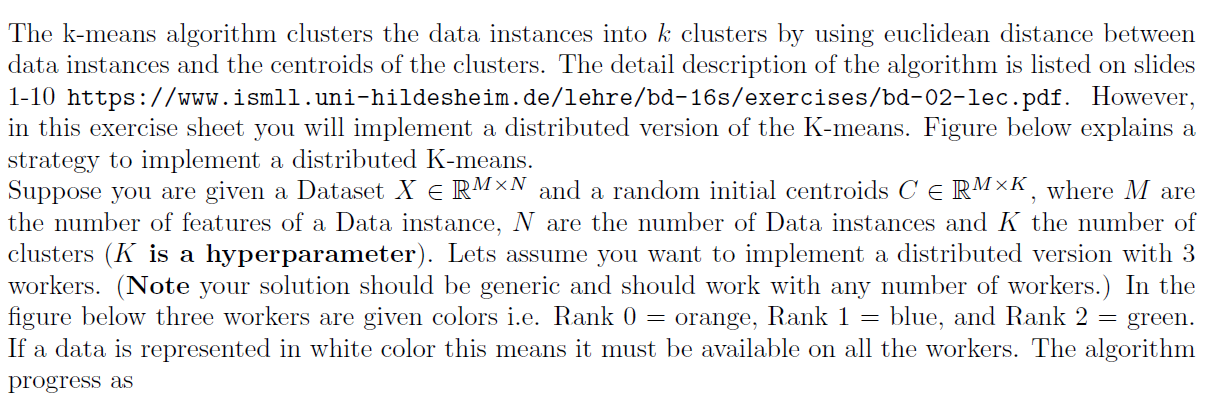

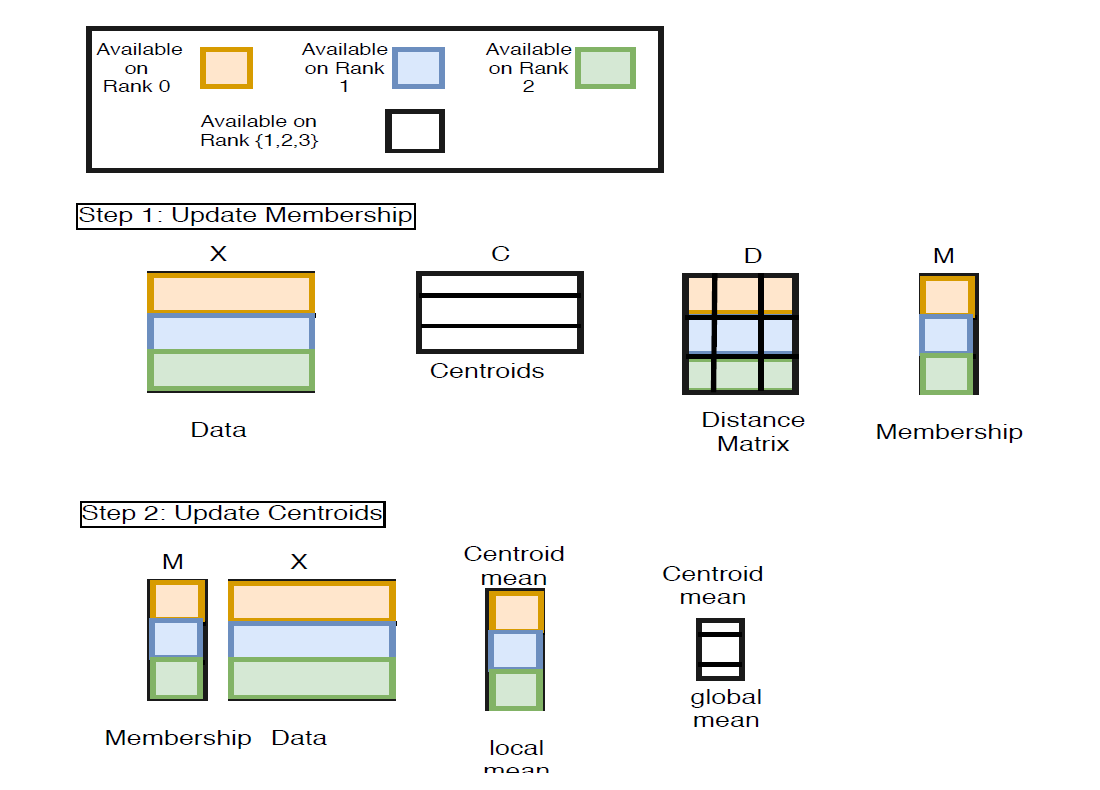

### My system wasn't working with all the categories in the newsgroup data. Below I have used maximum number of categories my system could handle becasue of the memory error.

### Firstly I have used Sklearn to fetch tfidf vector and used it in the compressed matrix form for distributing among workers. Each worker recieves its chunk along with the randomly initialized centroids and return the local means. After gathering all the local means from each of the worker, the master node calculates the global mean. This process of calculating the global means is continued until the global mean doesnot change anymore and finally the master node returns this global mean.


In [ ]:
# importing Libraries
import numpy as np
np.random.seed(0)
import pandas as pd
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from mpi4py import MPI

# Setting MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Initializing centroids and data chunks to None
centroids = None
data_chunks = None
K = 3              # number of centroids

def K_means_local(data, classes):      # function calculates local means for workers
    local_centroids = []
    for k in range(classes.shape[0]):
        c = 0
        summ = 0
        for i, instance in enumerate(data):    # for each data point the membership array gives the cluster
            if i == k:                             # for that instance
                c += 1
                summ += instance                  # summing over all the instances for the same class
        local_centroids.append(summ/c)
    return local_centroids

startTime = MPI.Wtime()                   
if rank == 0:
    categories = ['alt.atheism','talk.religion.misc', 'comp.graphics', 'sci.space','misc.forsale', 'comp.windows.x', 'talk.politics.misc']
    newsgroups = fetch_20newsgroups(subset = 'train', categories = categories)
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(newsgroups.data)
    M, N = vectors.shape
    step = M//size

    centroids = np.random.uniform(0, 1, size = (K, N))  # centroids initialized using uniform distribution
    
    data_chunks = []                  # splitting data for distribution among workers
    for i in range(size - 1):
        data_chunks.append(vectors[i*step:(i+1)*step, :])
    data_chunks.append(vectors[(size - 1)*step:, : ])

centroid = comm.bcast(centroids, root = 0)    # broadcasting centroids among all workers
worker_chunk = comm.scatter(data_chunks, root = 0)   # scattering data among all workers
M_chunk, N_chunk = worker_chunk.shape 
K_chunk = centroid.shape[0]

changeInCentroid = True                
while changeInCentroid:       # this condition checks if old global mean and new global mean are same
    Distance_matrix = np.zeros((M_chunk, K_chunk))
    for i, ele in enumerate(worker_chunk.toarray()):
        for j, center in enumerate(centroid):
            Distance_matrix[i, j] = np.linalg.norm(ele - center)    # calculating distance using Euclidean norm

    membership = np.argmin(Distance_matrix, axis=1).reshape(-1, 1)   # Assigning the class to datapoints from which 
                                                                           # distance to the centroid is minimum
    local_means = K_means_local(worker_chunk.toarray(), membership)

    LocalMeans = comm.gather(local_means, root = 0)

    global_mean = []    # global means are calculated by gathering local means from all workers and then averaging them
    if rank == 0:
        for k in range(K):
            local_sum = 0
            for means in LocalMeans:
                local_sum += means[k]
            global_mean.append(local_sum/K)

        total_clusters = 0   # condition checks if elements of old global means are same as new global means
        for i in range(K):
            if all(item in centroid[i] for item in global_mean[i]):
                total_clusters += 1

        if total_clusters == K:       # if same then exit the while loop
            changeInCentroid = False

    else:
        global_mean = None

    centroid = global_mean           # swapping old global mean with the new global mean
    centroid = comm.bcast(centroid)     # new means are broadcasted among workers
    changeInCentroid = comm.bcast(changeInCentroid)

if rank == 0:
    print(global_mean)
    print('Time:', MPI.Wtime()-startTime)

### The snippet below is an example where clustering is performed for 10 centroids using 8 processors.
### The returned global means are also sparse vectors.

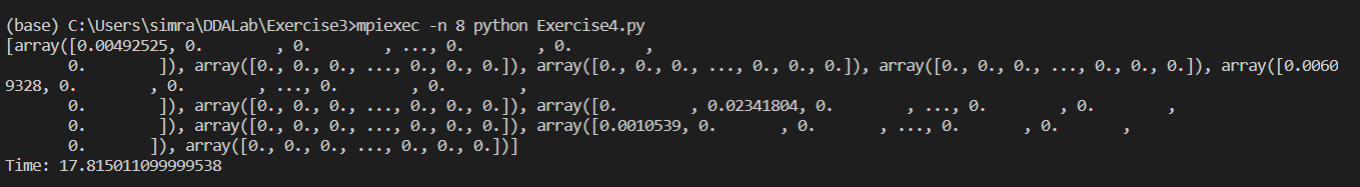

### The snippet below shows for a particular number of clusters and using 4 processors, the global means are changed for the following number of times i.e., for as many times we enter the while loop.

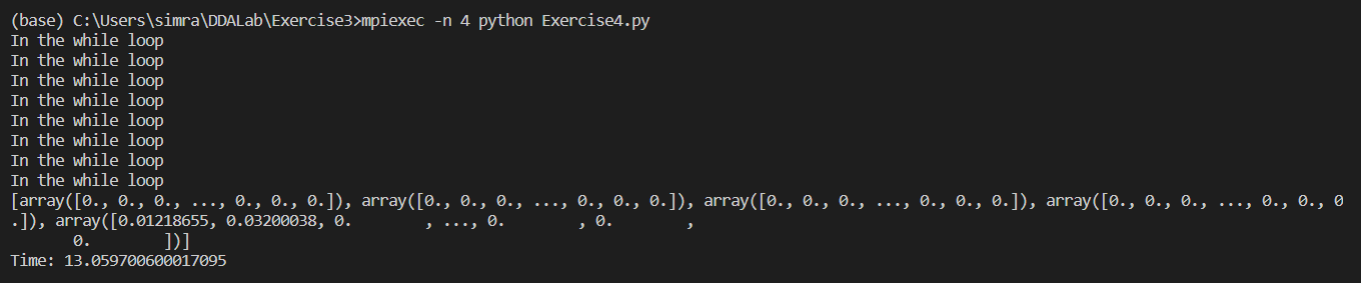

## Plotting the table for the processing time taken by different workers for different number of clusters.

In [28]:
import pandas as pd
worker_cluster = {'P:1':[20.51608830000623, 22.366360500018345, 25.205691699986346, 28.918690300022718],
                'P:2': [13.031800500000827, 14.967241600010311, 17.419258799985982, 20.164706999988994],
                'P:4': [11.452122200018493, 12.73154280000017, 14.40143420000095, 18.062123399984557],
                'P:6': [10.815635600010864, 12.329959599999711, 14.318328599998495, 16.31832309998572],
                'P:8': [10.891213700000662, 13.07798780000303, 13.748115299997153, 17.815011099999538]
    }

time = pd.DataFrame.from_dict(worker_cluster, orient = 'index')
time.columns = ['K:3', 'K:5', 'K:7', 'K:10']
time2 = time.style.set_properties(**{
    'background-color': 'grey',
    'font-size': '20pt',
})
time2

,K:3,K:5,K:7,K:10
P:1,20.516088,22.366361,25.205692,28.918690
P:2,13.031801,14.967242,17.419259,20.164707
P:4,11.452122,12.731543,14.401434,18.062123
P:6,10.815636,12.329960,14.318329,16.318323
P:8,10.891214,13.077988,13.748115,17.815011


## As the number of processors is increased, the processing time decreases with the exceptions in the end as more and more processors are introduced the communication among them is to be maintained which is added as an overhaed cost resulting in the increased processing time for the more number of processors. Also, as we increase the number of clusters among which the data is divided the processing time is increased as the distance matrix calculation is increased when using more clusters.

# Speed Up

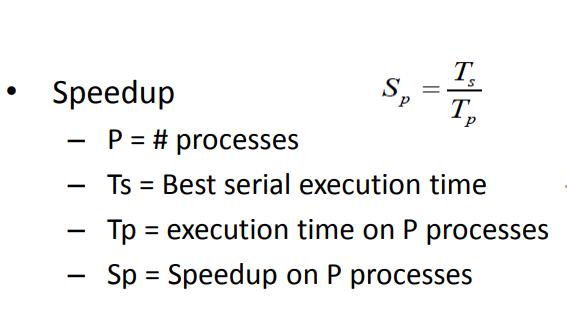

In [29]:
def speedup(p1, pp):
    return p1/pp

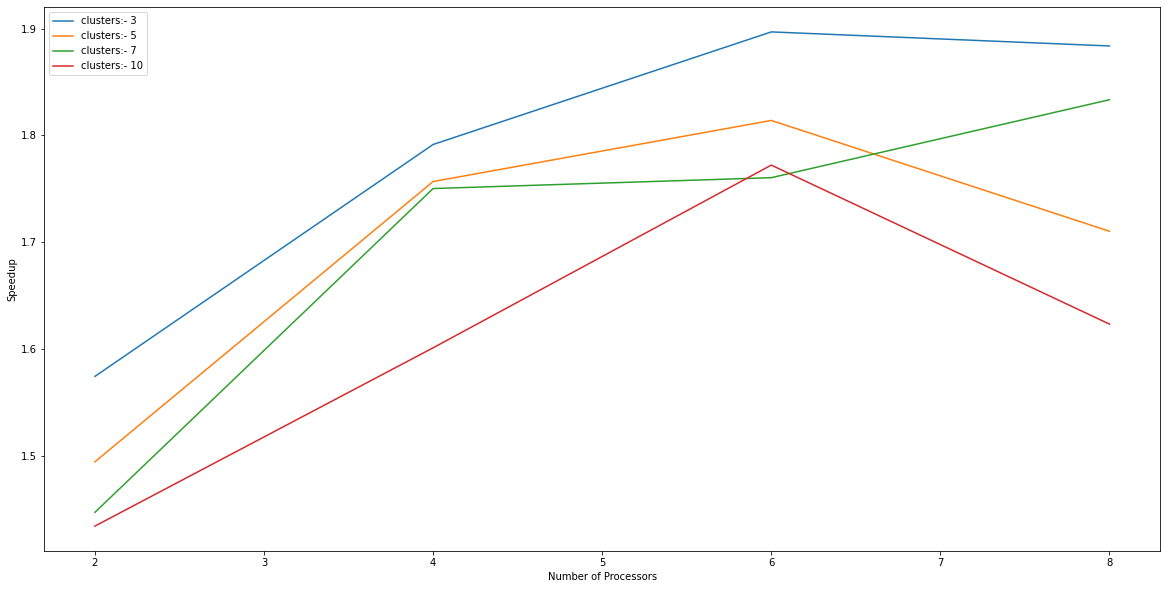

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 10))
for j,k in enumerate([3, 5, 7, 10]):
    cluster = []
    for i in range(5):
        cluster.append(time.iloc[i, j])
    speed_clus = [speedup(cluster[0], cluster[j]) for j in range(1,5)]
    plt.plot([2,4,6,8], speed_clus, label = f'clusters:- {k}')
plt.legend()
plt.xlabel('Number of Processors')
plt.ylabel('Speedup')
plt.show()

## Comparing our plot to the graph below, when using 3, 5 and 10 clusters we get sub-linear speedup but when using 10 clusters we get super-linear speedup which is good. Since speedup is given by the division of time taken by sequential execution to the time taken by parallel execution and larger the speedup implies that the time taken by parallel execution is very less as compared to the sequential execution and vice-versa.

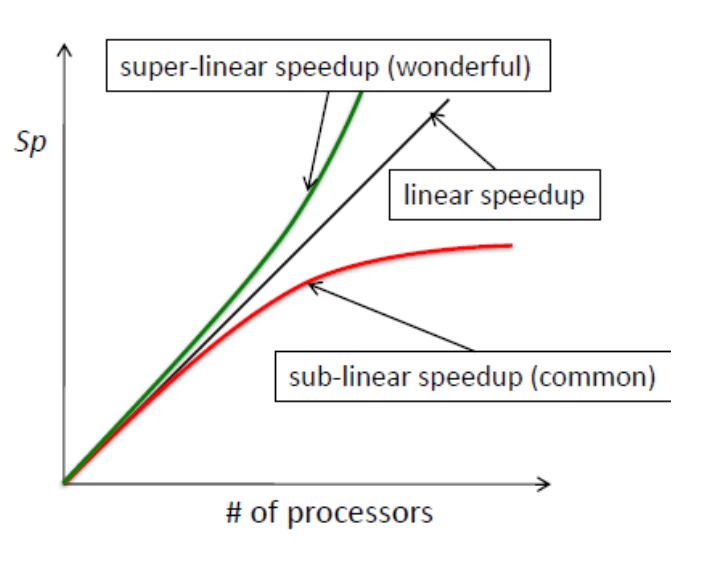